# Obenter matriz de adyacencia entre grupos

Ya que los puntos del grafo original pertenecen a 35 grupos, es necesario realizar la matriz de adyacencia que conecte únicamente los centros. Esto servirá para realizar una consulta a Google Api sobre el tiempo que se tarda viajar de un grupo al siguiente.

In [1]:
import osmnx as ox
import networkx as nx 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Se carga el modelo de grupos y los colores.

In [2]:
import pickle
with open('Cluster_map.pickle', 'rb') as handle:
    graph = pickle.load(handle)

In [3]:
colors_data = pd.read_csv('colores_mapa.csv')

In [4]:
colors_num = list(colors_data['colors'])

In [5]:
colors_num[:10]

[0, 0, 29, 21, 21, 13, 14, 12, 12, 4]

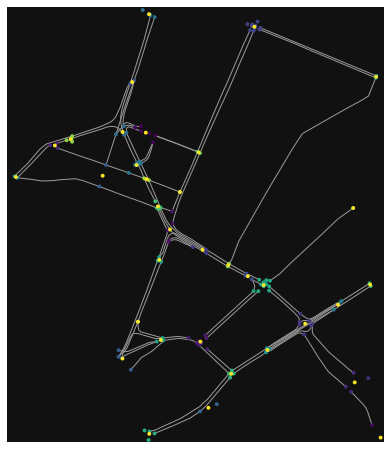

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
ox.plot_graph(graph, 
             node_color=colors_num)

Se lee el dataset que contiene los puntos del mapa y el grupo al que pertenecen.

In [20]:
data = pd.read_csv('nodos_dataset.csv')

In [8]:
data.head()

,Unnamed: 0,nodos,position_x,position_y,centro_x,centro_y,cluster
0,0,264268562,-78.500598,-0.202221,-78.500401,-0.202488,0
1,1,264268564,-78.500014,-0.202610,-78.500401,-0.202488,0
2,2,264268569,-78.498284,-0.203269,-78.498235,-0.203297,29
3,3,264270346,-78.490999,-0.200246,-78.490986,-0.200207,21
4,4,264270354,-78.490973,-0.200167,-78.490986,-0.200207,21


Se extraen las calles del grafo para conocer qué puntos individuales están conectados y transformarlo en conexiones entre centros de grupos. 

In [7]:
edges = list(graph.edges())

Hay que recordar que las conexiones entre nodos del mismo grupo fueron eliminadas, así que las edges restantes conectan distindos grupos.

In [8]:
edges[:10]

[(264268564, 264268569),
 (264268569, 267939607),
 (264268569, 264268564),
 (264270346, 267939758),
 (264270354, 3726280025),
 (267036924, 267960698),
 (267036924, 3726294618),
 (267036926, 4207542605),
 (267036926, 267036924),
 (267036927, 267939876)]

In [9]:
len(edges)

90

Se crea la base de la matriz de adyacencia. 

In [12]:
adj_matrix = np.zeros((35,35))

In [13]:
adj_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Ya que las calles pueden ser de doble vía, habrá conexiones que unen dos grupos en ambos sentidos. Sin embargo, no todos los grupos van a estar conectados de esta forma, esto da como resultado una matriz de adyacencia que no será simétrica. El resultado final será un grafo no dirigido.

In [14]:
graph.edges[(264268564, 264268569, 0)]

{'osmid': [356064688, 107938398],
 'oneway': False,
 'name': 'San Gregorio',
 'highway': 'tertiary',
 'length': 205.81,
 'geometry': <shapely.geometry.linestring.LineString at 0x21d95519b80>}

Oneway significa que va en una sola dirección, por lo tanto, esta condición se traduce como un 1 en la matriz de adyacencia. Si oneway es falso, se colocan dos 1 para representar la conexión de ida y vuelta entre dos grupos.

In [15]:
for nodo1,nodo2 in edges:
    #se obtienen los grupos a los que pertenecen los puntos
    #o nodos del mapa-grafo original
    cluster1 = int(data['cluster'][np.where(data['nodos']==nodo1)[0]])
    cluster2 = int(data['cluster'][np.where(data['nodos']==nodo2)[0]])
    #conexión principal entre dos grupos
    adj_matrix[cluster1][cluster2] = 1    
    #si es doble vía
    if (not graph.edges[(nodo1,nodo2,0)]['oneway']):
        adj_matrix[cluster2][cluster1] = 1 
        

Se puede visualizar la matriz de adyacencia para comprobar que no es simétrica. Existen 35 filas por 35 columnas que representan los grupos y las conexiones entre ellos.

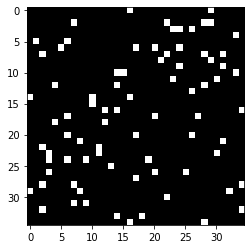

In [16]:
plt.imshow(adj_matrix,'gray')

Cada fila de la matriz representa los vecinos del grupo actual. El grupo 0 tiene como vecinos a los grupos 16 y 29.

In [17]:
np.where(adj_matrix[0]==1)

(array([16, 29], dtype=int64),)

In [29]:
np.where(adj_matrix[16]==1)

(array([12, 14, 34], dtype=int64),)

Con esta matriz de adyacencia se puede desplegar un modelo simplificado que tiene los centros de los grupos y las conexiones entre ellos.

In [22]:
G = nx.DiGraph(adj_matrix)

Se utilizan las ubicaciones de los centros, que se encuentran almacenadas en un txt, para realizar un gráfico con ubicaciones similares a las del mapa.

In [1]:
centros = [(-78.50040125, -0.20248826666666667),
 (-78.49079993333334, -0.21495733333333333),
 (-78.49941296, -0.20644891999999998),
 (-78.4981667125, -0.21103442500000003),
 (-78.50411983333333, -0.20301313333333335),
 (-78.491860325, -0.2126993),
 (-78.49388817142858, -0.21029951428571433),
 (-78.498081775, -0.20728062500000002),
 (-78.49596283, -0.19816061999999998),
 (-78.49622876666668, -0.2083583),
 (-78.50095725, -0.20041799999999999),
 (-78.5013562, -0.211726575),
 (-78.5021648, -0.2042497),
 (-78.4978411, -0.21373910000000002),
 (-78.5013519, -0.20246205),
 (-78.50026352500001, -0.197645025),
 (-78.5007766, -0.20381238333333332),
 (-78.49254119999999, -0.20952433333333334),
 (-78.50571395, -0.20430165),
 (-78.4919239, -0.20557),
 (-78.49542793333333, -0.21137536666666668),
 (-78.49098605, -0.20020670000000002),
 (-78.49984930000001, -0.20768993333333333),
 (-78.49978503333334, -0.21096573333333335),
 (-78.49558266363637, -0.20872455454545458),
 (-78.500259975, -0.214803425),
 (-78.49691080000001, -0.21235037499999998),
 (-78.4912293, -0.208703),
 (-78.499905125, -0.205504975),
 (-78.49823549999999, -0.2032972),
 (-78.5007215, -0.2102183),
 (-78.49702765, -0.2079013),
 (-78.4990074, -0.2049163),
 (-78.50347635, -0.20275515),
 (-78.5003718, -0.2043924)]

Se guardan los centros como un objeto para que su uso sea más fácil.

In [3]:
a = centros
with open('coordenadas_centros.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

Se utiliza un diccionario para extraer los nombres de los nodos del modelo simplificado.

In [30]:
lab_dict = {}
for nodo in G.nodes:
    lab_dict[nodo] = nodo

El modelo simplificado muestra los centros de los grupos y las conexiones direccionadas que existen entre cada grupo.

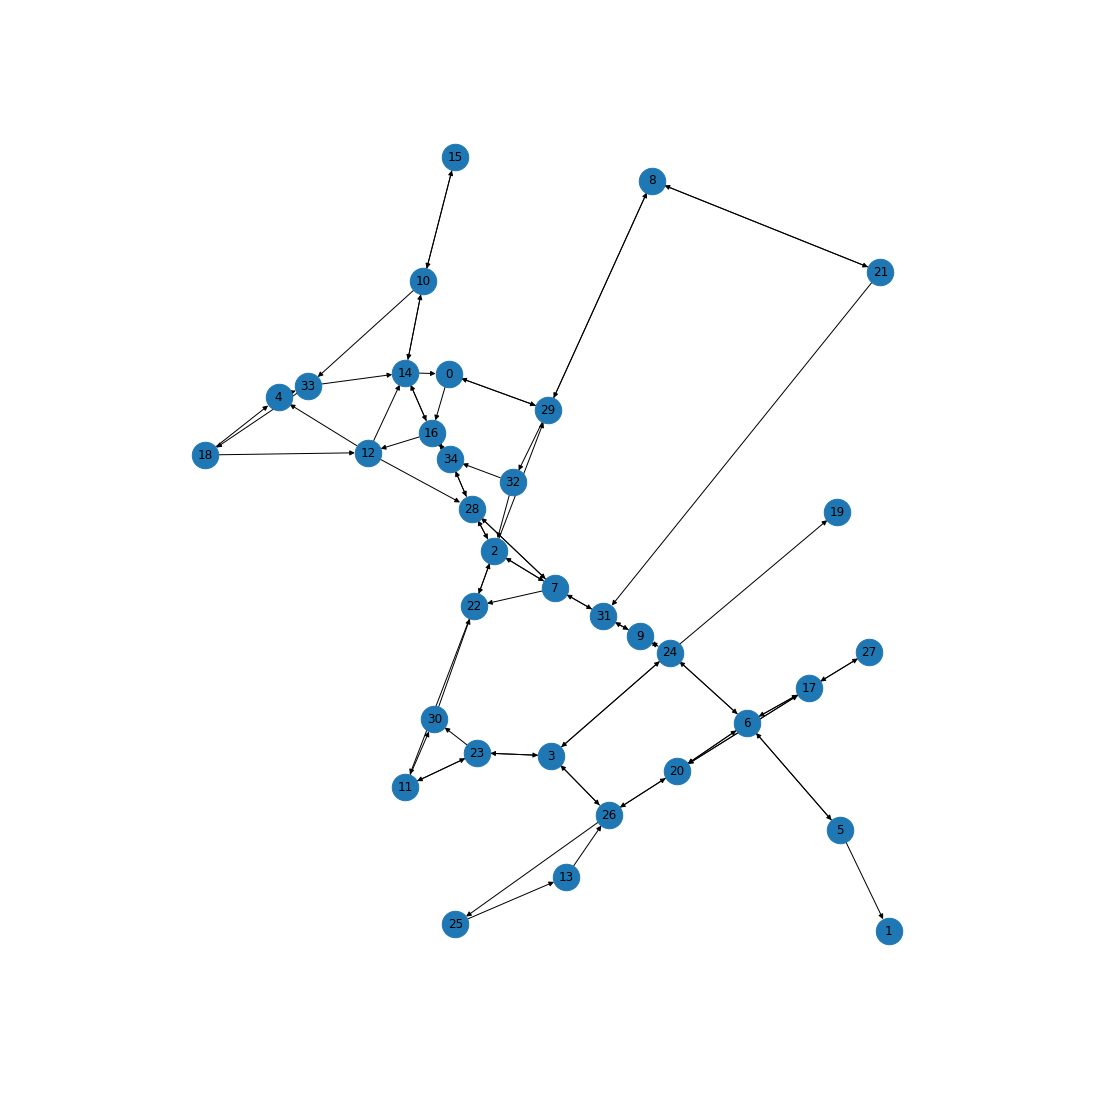

In [36]:
plt.figure(figsize=(15,15))

nx.draw(G,centros,
        node_size=700,
        labels=lab_dict,
        with_labels=True)

Se guarda la información de la matriz de adyacencia junto con la ubicación de los centros.

In [39]:
data_centers = pd.DataFrame(adj_matrix)

In [40]:
data_centers['cluster_point'] = centros

In [42]:
data_centers.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,cluster_point
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(-78.50040125, -0.20248826666666667)"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.49079993333334, -0.21495733333333333)"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"(-78.49941296, -0.20644891999999998)"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-78.4981667125, -0.21103442500000003)"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(-78.50411983333333, -0.20301313333333335)"


In [43]:
data_centers.to_csv(r'centros_googleApi.csv')

Esta información será utilizada para realizar una consulta a Google API que involucra los centros de los grupos. Es decir, el modelo simplificado.

## Modelo que conserva las conexiones originales

También se conserva un modelo que tiene las calles originales de networkx para poder utilizarlo en el futuro siguientes. Este modelo está compuesto únicamente por los centros, ya no los puntos del mapa original.

In [101]:
new_model = graph.copy()

Se agregan 35 nodos para los centros.

In [102]:
inicio_centros = max(graph.nodes)-34

Se transfiere las ubicaciones a los centros.

In [103]:
for i in range(35):
    new_model.add_node(i)
    new_model.nodes[i]['x'] = graph.nodes[inicio_centros+i]['x']    
    new_model.nodes[i]['y'] = graph.nodes[inicio_centros+i]['y']

Se recorren las conexiones originales para crear copias en el nuevo modelo.

In [104]:
for nodo1,nodo2 in edges[:1]:
    for elements in graph.edges[(nodo1,nodo2,0)]:
        print(elements)

osmid
oneway
name
highway
length
geometry


Se reconectan las calles y se eliminan las conexiones anteriores.

In [105]:
for nodo1,nodo2 in edges:
    #se obtienen los grupos a los que pertenecen los puntos
    #o nodos del mapa-grafo original
    cluster1 = int(data['cluster'][np.where(data['nodos']==nodo1)[0]])
    cluster2 = int(data['cluster'][np.where(data['nodos']==nodo2)[0]])
    #nuevas edges
    new_model.add_edge(cluster1,cluster2)
    for element in graph.edges[(nodo1,nodo2,0)]:    
        new_model.edges[(cluster1,cluster2,0)][element] = graph.edges[(nodo1,nodo2,0)][element]
    new_model.remove_edge(nodo1,nodo2)
        

Se eliminan todos los nodos que no son parte de los centros.

In [115]:
for nodo in graph.nodes:
    new_model.remove_node(nodo)

Se puede ver que la información de las calles se conservó,
    

In [122]:
new_model.edges[(0,16,0)]

{'osmid': 426468658,
 'oneway': True,
 'lanes': '1',
 'name': 'Versalles',
 'highway': 'tertiary',
 'length': 110.22899999999998,
 'geometry': <shapely.geometry.linestring.LineString at 0x1b5b76f41f0>,
 'maxspeed': '50',
 'access': 'yes'}

In [123]:
new_model.edges[(2,7,0)]

{'osmid': 534516113,
 'oneway': True,
 'lanes': '1',
 'highway': 'primary_link',
 'maxspeed': '50',
 'length': 119.87800000000001,
 'geometry': <shapely.geometry.linestring.LineString at 0x1b5b76f47f0>}

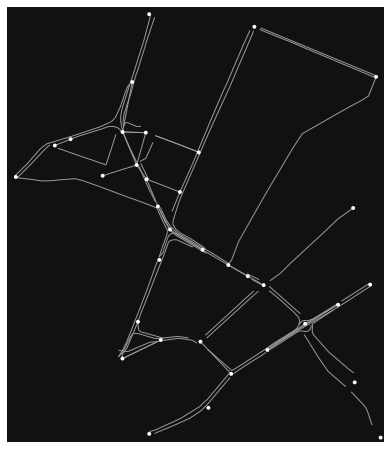

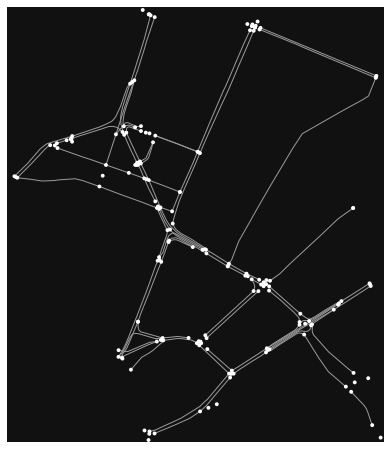

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [129]:
#nuveo modelo simplificado
ox.plot_graph(new_model)
#modelo original
ox.plot_graph(graph)


In [119]:
len(graph.edges)

90

In [120]:
len(new_model.edges)

90

Se guarda el modelo que conserva las calles.

In [132]:
a = new_model
with open('cluster_model.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)